# Two-level molasses in 1D

This example covers a two level, 1D optical molasses and compares results to
P. D. Lett, et. al., _J. Opt. Soc. Am. B_ __6__, 2084 (1989).  This example is an excellent oppportunity to review the subtlties, like integration time and binning, of extracting accurate temperatures, even under the most basic approximations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import lmfit
import pathos # used for parallelization
from scipy.stats import iqr
from pylcp.common import progressBar

## Define the problem

As with every example in `pylcp`, we must first define the Hamiltonian, lasers, and magnetic field.  We will make a two-state system that is addressed only by $\pi$ polarized light.  Note that because we are also using the heuristic equation, we want to make sure that the detuning is not on the Hamiltonian, but on the lasers.

In [2]:
mass = 50

# Make a method to return the lasers:
def return_lasers(delta, s):
    return pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 's':s},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 's':s},
        ], beam_type=pylcp.infinitePlaneWaveBeam)

# Now define a two level Hamiltonian, connected using pi-light.
def return_hamiltonian(delta):
    Hg = np.array([[0.]])
    He = np.array([[-delta]])
    mu_q = np.zeros((3, 1, 1))
    d_q = np.zeros((3, 1, 1))
    d_q[1, 0, 0] = 1.

    return pylcp.hamiltonian(Hg, He, mu_q, mu_q, d_q, mass=mass)

hamiltonian = return_hamiltonian(0.)

magField = lambda R: np.zeros(R.shape)

## Calculate equilibrium forces
### Generate the equilibrium force profile

Do it for all three governing equations at the same step.

In [3]:
delta = -2.
s = 1.5

laserBeams = return_lasers(delta, s)
hamiltonian = return_hamiltonian(0.)
eqns = {}
eqns['obe'] = pylcp.obe(laserBeams, magField, hamiltonian)
eqns['rateeq'] = pylcp.rateeq(laserBeams, magField, hamiltonian)
eqns['heuristiceq'] = pylcp.heuristiceq(laserBeams, magField)

extra_args = {}
extra_args['obe'] = {'progress_bar':True, 'deltat_tmax':2*np.pi*100, 'deltat_v':4,
                     'itermax':1000, 'rel':1e-4, 'abs':1e-6}
extra_args['rateeq'] = {}
extra_args['heuristiceq'] = {}

v = np.arange(-10., 10.1, 0.1)

for key in eqns:
    eqns[key].generate_force_profile(np.zeros((3,) + v.shape),
                                     [v, np.zeros(v.shape), np.zeros(v.shape)],
                                     name='molasses', **extra_args[key])

Completed in 24.36 s.                                               


Plot up the equilibrium force profile, solid for the OBEs, dashed for the rate equations, and dashed-dot for the heuristic equation.

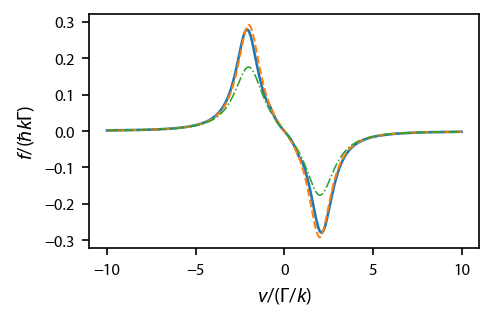

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(3.25, 2.))
lbls = {'obe':'OBE', 'rateeq':'Rate Eq.', 'heuristiceq':'Heuristic Eq.'}
styles = ['-','--','-.']
for ii, key in enumerate(eqns):
    ax.plot(v, eqns[key].profile['molasses'].F[0], styles[ii],
            label=lbls[key], linewidth=1.25-0.25*ii)
    #ax[1].plot(v, eqn.profile['molasses'].Neq)
#ax.legend(fontsize=7)
ax.set_xlabel('$v/(\Gamma/k)$')
ax.set_ylabel('$f/(\hbar k \Gamma)$')
fig.subplots_adjust(bottom=0.2)

For the rate equations and the OBEs, also plot up the equilibrium populations of the two states:

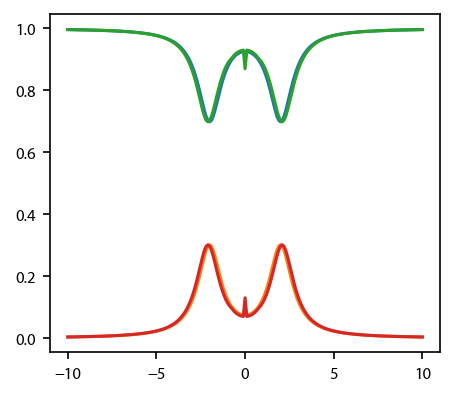

In [5]:
fig, ax = plt.subplots(1, 1)
for key in ['rateeq', 'obe']:
    #ax[0].plot(v, eqn[key].profile['molasses'].F[0])
    ax.plot(v, eqns[key].profile['molasses'].Neq)

### Calculate the damping parameter
We calculate the damping coefficient $\beta$ as a function of $s_0$ and $\delta$, and compare to the Lett expression for the damping.

In [6]:
deltas = np.linspace(-3, 0., 101)
intensities = np.array([0.01, 0.1, 1, 10])

betas = {}
Deltas, Intensities = np.meshgrid(deltas, intensities)

eqns = {'heuristiceq':pylcp.heuristiceq, 'rateeq':pylcp.rateeq, 'obe':pylcp.obe}

extra_args['obe'] = {'deltat':2*np.pi*100, 'itermax':1000, 'rel':1e-4, 'abs':1e-6}
extra_args['rateeq'] = {}
extra_args['heuristiceq'] = {}

for key in eqns:
    it = np.nditer([Deltas, Intensities, None])
    progress = progressBar()
    for (delta, intensity, beta) in it:
        laserBeams = return_lasers(delta, intensity)
        hamiltonian = return_hamiltonian(0.)

        # Next, generate the OBE or rate equations:
        if key is 'heuristiceq':
            eqn = eqns[key](laserBeams, magField)
        else:
            eqn = eqns[key](laserBeams, magField, hamiltonian)

        # Use built in damping_coefficient() method:
        beta[...] = eqn.damping_coeff(axes=[0], **extra_args[key])

        progress.update((it.iterindex+1)/it.itersize)

    # Just update it to be sure.
    progress.update(1.)

    betas[key] = it.operands[2]

Completed in 0.43 s.                                              
Completed in 0.90 s.                                               
Completed in 9:30.                                                  


Plot it up:

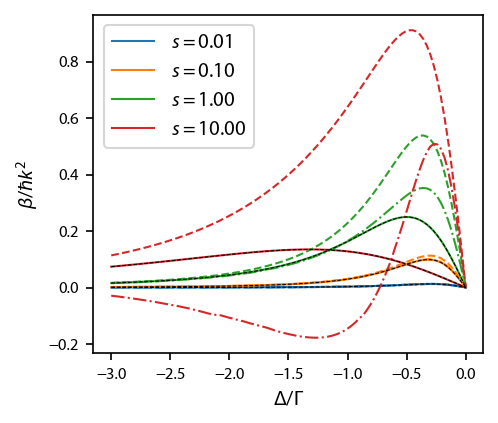

In [7]:
fig, ax = plt.subplots(1, 1)
for ii, key in enumerate(eqns):
    for jj, betas_i in enumerate(betas[key]):
        if ii==0:
            kwargs = {'label':'$s=%.2f$'%intensities[jj]}
        else:
            kwargs = {}
        ax.plot(deltas, betas_i, styles[ii], color='C%d'%jj, linewidth=1., **kwargs)

for ii, intensity in enumerate(intensities):
    ax.plot(deltas, -4*intensity*2*deltas/(1+2*intensity+4*deltas**2)**2, 'k--',
             linewidth=0.5)
    
ax.legend(loc='upper left')
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$\\beta/\hbar k^2$');

## Simulate many atoms to extract temperature

We'll run about $N_A\approx 250$ for a time $\tau$ to generate some histograms and understand what velocities we obtain, etc.

Because we start at $v=0$, the amount of time that we will need to integrate for will depend both on the mass and the scattering rate.  We must integrate for sufficiently long to allow the atoms's velocity to randomly walk to a standard deviation that corresponds to a temperature $T$.  Using the basic Doppler limit $T_D=\hbar \Gamma/(2 k_B)$, the expected standard deviation in the velocity at $T$ is given by

$$
    \sigma_v^2 = \frac{k_B T}{m} = \frac{k_B}{m}\left(\frac{\hbar \Gamma}{2 k_B}\right)\frac{T}{T_D} = \frac{1}{2} \frac{\hbar k}{m}\frac{\Gamma}{k}\frac{T}{T_D} = \frac{v_R v_D}{2}\frac{T}{T_D},
$$

where the "Doppler velocity" is $v_D = \Gamma/k$ and the recoil velocity is $v_R = \hbar k/M$.  In our default unit system, $t_0 = 1/\Gamma$, $x_0=1/k$, and the dimensionless mass, defined above simply as the variable `mass`, is $\bar{M} = x_0^2 M/ \hbar t_0 = \Gamma M/ \hbar k^2$. In these units, velocity is measured in $v_D$, so the corresponding dimensionless standard deviation $\bar{\sigma}_v$ is given by,

$$
    \bar{\sigma}_v^2 = \frac{\sigma_v^2}{v_D^2} = \frac{1}{2\bar{M}}\frac{T}{T_D}
$$

where we have used the fact that the dimensionless mass can be written as $\bar{M} = v_D/v_R$.

Now, assuming that the atoms' velocity engages in a random walk, after $N_{\rm sc}$ scattering events, the atoms' velocity will have a variance of $\sigma_v^2/v_R^2 = N_{\rm sc}$ (assuming 2 recoils per scattering event and equal probability scattering left or right).  Thus, we need at least $N_{\rm sc} = \sigma_v^2/v_R^2 = \bar{\sigma_v}^2 (v_D/v_R)^2 = \bar{M}/2 (T/T_D)$ scattering events.

To turn this into an integration time, we need a rough estimate of the scattering rate $R_{\rm sc}$. From the heuritistic equation,

$$
    R_{\rm sc}=\frac{\Gamma}{2}\frac{s}{1+2s+4\delta^2}
$$

for a given detuning $\delta = \Delta/\Gamma$ and saturation parameter $s$.  Thus, the dimensionless total evolution time $\bar{\tau}$ should be *at least*

$$
    \bar{\tau} \geq \bar{M}\frac{T}{T_D} \frac{1+2s+4\delta^2}{s}
$$

In practice, we might expect the maximum $T/T_D\approx 10$.

#### Non parallel version:

Plots up the first ten runs.

```
s = 3
delta = -1

laserBeams = return_lasers(delta, s)
hamiltonian = return_hamiltonian(0.)

eqn = pylcp.heuristiceq(laserBeams, magField, mass=mass)
#eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
#eqn = pylcp.obe(laserBeams, magField, hamiltonian)

N_atom = 256
v_final = np.zeros((N_atom,))
#num_of_scatters = np.zeros((N_atom,), dtype='int')
#num_of_steps = np.zeros((N_atom,), dtype='int')

fig, ax = plt.subplots(1, 1)
sols = []
progress = progressBar()
for ii in range(N_atom):
    eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]), np.array([0., 0., 0.]))
    if isinstance(eqn, pylcp.rateeq):
        eqn.set_initial_pop_from_equilibrium()
    elif isinstance(eqn, pylcp.obe):
        eqn.set_initial_rho_from_rateeq()

    eqn.evolve_motion([0., 10*mass*(1+2*s+4*np.abs(delta)**2)/s],
                      random_recoil=True,
                      max_scatter_probability=0.25,
                      freeze_axis=[False, True, True])
    progress.update((ii+1.)/N_atom)

    if ii<10:
        ax.plot(eqn.sol.t, eqn.sol.v[0])

    v_final[ii] = eqn.sol.v[0, -1]

    sols.append(eqn.sol)
    #num_of_scatters[ii] = sum(eqn.sol.n_random)
    #num_of_steps[ii] = len(eqn.sol.t)

ax.set_xlabel('$\Gamma t$')
ax.set_ylabel('$v/(\Gamma/k)$');
```

#### Parallel version:

Adjust chunksize to equal the number of cores.

In [3]:
s = 3
delta = -1

laserBeams = return_lasers(delta, s)
hamiltonian = return_hamiltonian(0.)

#eqn = pylcp.heuristiceq(laserBeams, magField, mass=mass)
eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)
#eqn = pylcp.obe(laserBeams, magField, hamiltonian)

eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]), np.array([0., 0., 0.]))
if isinstance(eqn, pylcp.rateeq):
    eqn.set_initial_pop_from_equilibrium()
elif isinstance(eqn, pylcp.obe):
    eqn.set_initial_rho_from_rateeq()

N_atom = 256 # Needs to be divisible by chunksize

if hasattr(eqn, 'sol'):
    del eqn.sol

def generate_random_solution(eqn, tmax, rng_seed):
    # We need to generate random numbers to prevent solutions from being seeded
    # with the same random number.
    eqn.evolve_motion(
        [0., tmax],
        random_recoil=True,
        max_scatter_probability=0.25,
        freeze_axis=[False, True, True],
        rng=np.random.default_rng(rng_seed)
    )
    
    return eqn.sol.v[0, -1]

chunksize = 4
v_final = []
ss = np.random.SeedSequence(12345) # "It's the same combination as my luggage!"
child_seeds = ss.spawn(N_atom)
progress = progressBar()
for jj in range(int(N_atom/chunksize)):
    with pathos.pools.ProcessPool(nodes=4) as pool:
        v_final += pool.map(
            generate_random_solution,
            chunksize*[eqn],
            chunksize*[10*mass*(1+2*s+4*np.abs(delta)**2)/s],
            child_seeds[jj*chunksize:(jj+1)*chunksize]
        )
    progress.update((jj+1)/int(N_atom/chunksize))

Completed in 8:27.                                                  


Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 44, in mapstar
   

This should be zero, but it might not be because of bad seeding of random number generators during parallel execution:

In [4]:
np.sum(np.diff(np.sort(v_final))==0)

0

### Bin the final data and extract temperature

To extract the final temperature with uncertainity, we must calculate $\sigma_v$ and its uncertainty.  The standard error in $\sigma$ for a Gaussian distribution is $\sigma/\sqrt{2 N-2}$ for $N$ points.  However, we will obtain more accurate estimates of the uncertainty by restricting the Gaussian distribution such that the mean is zero.  To do this systematically, we will bin the data and fit the resulting histogram.

We use the Freedman–Diaconis rule to determine the bin size, and use bins that are symmetric about zero and span the whole range of $v_{\rm final}$.  We normalize the counts in each bin to $N_A$, which gives us the "experimental" (i.e., through the numerics) probability of landing in the bin between $x-dx/2$ and $x+dx/2$.  We then fit the numerics to the associated expectation from a normal distribution given by $p(x)dx$, where $p(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$, $\sigma$ is the standard deviation, and $\mu$ is the mean.  Because the bin size here is fixed and known, we eliminate one additional variable compared to `lmfit`'s built in Gaussian model, namely the amplitude.

Finally, we will also plot the distribution expected from Lett, *et. al.*.

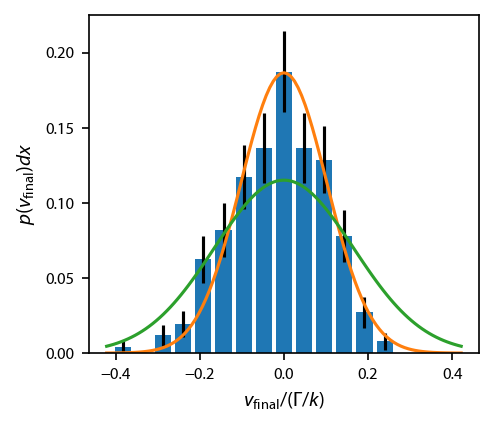

In [5]:
#print(2*np.std(v_final)**2*mass)
def normaldist(x, mu, sigma, dx):
    # Gaussian probability distribution function 
    # probability of landing in a bin of width dx is p(x)dx
    return dx/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def lett_temperature(s, delta):
    """
    Returns the ratio of the expected temperature relative to the "bare" Doppler temperature.
    """
    return 0.5*(1+2*s+4*delta **2)/2/np.abs(delta)

def fit_vfinal(v_final, N_atom):
    dx = 2*iqr(v_final)/N_atom**(1/3)
    xb = np.arange(dx/2, 1.1*np.amax(np.abs(v_final)), dx)
    xb = np.concatenate((-xb[::-1], xb))
    
    x = xb[:-1] + np.diff(xb)/2
    y = np.histogram(v_final, bins=xb)[0]/N_atom #Probability of an atom landing in this bin.'
    
    ok = (y>0)
    weights = np.zeros(ok.shape)
    weights[ok] = 1./(y[ok]/N_atom)
    model = lmfit.Model(normaldist)
    params = model.make_params()
    params['dx'].value = dx # bin width, probability of landing in the bin is p(x) dx
    params['dx'].vary = False
    params['mu'].value = 0.
    params['mu'].vary = False
    params['sigma'].value = np.std(v_final)
    
    result = model.fit(y[ok], params, x=x[ok], weights=weights[ok])

    return result, x, y, dx

result, x, y, dx = fit_vfinal(v_final, N_atom)

fig, ax = plt.subplots(1, 1)

ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error

x_fit = np.linspace(-1.1*np.amax(np.abs(v_final)), 1.1*np.amax(np.abs(v_final)), 101)

ax.plot(x_fit, result.eval(x=x_fit))
ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(s, delta)/2/mass), dx))
ax.set_ylabel('$p(v_{\\rm final}) dx$')
ax.set_xlabel('$v_{\\rm final}/(\Gamma/k)$');

### Measure the temperature vs. detuning and intensity 

We can compare to the formula in Lett, *et. al.*

In [13]:
deltas = np.array([-3, -2., -1., -0.5, -0.375, -0.25, -0.125])
intensities = np.array([0.3, 1, 3])

Deltas, Intensities = np.meshgrid(deltas, intensities)

N_atom = 250

v_final = {}
result = {}

# Make a progress bar:
progress = progressBar()
    
it = np.nditer([Deltas, Intensities, None, None])
for (delta, s, sigma, delta_sigma) in it:
    # First, generate the new laser beams and hamiltonian:
    laserBeams = return_lasers(delta, s)
    hamiltonian = return_hamiltonian(0.)

    # Next, generate the OBE, rate equations or heuristic eqn:
    eqn = pylcp.heuristiceq(laserBeams, magField, mass=mass)
    #eqn = pylcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)

    eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]),
                                               np.array([0., 0., 0.]))
    if isinstance(eqn, pylcp.rateeq):
        eqn.set_initial_pop_from_equilibrium()
    elif isinstance(eqn, pylcp.obe):
        eqn.set_initial_rho_from_rateeq()
                                          
    key = (float(delta), float(s))
    v_final[key] = np.zeros((N_atom,))
    
    # Now, evolve however many times:
    # Non-parallel version
#     for ii in range(N_atom):
#         eqn.evolve_motion([0., 10*mass*(1+2*s+4*np.abs(delta)**2)/s],
#                           random_recoil=True,
#                           max_scatter_probability=0.25,
#                           freeze_axis=[False, True, True])

#         v_final[key][ii] = eqn.sol.v[0, -1]

    # Parallel version
    v_final[key] = []
    ss = np.random.SeedSequence()
    child_seeds = ss.spawn(N_atom)
    for jj in range(int(N_atom/chunksize)):
        with pathos.pools.ProcessPool(nodes=4) as pool:
            v_final[key] += pool.map(
                generate_random_solution,
                chunksize*[eqn],
                chunksize*[10*mass*(1+2*s+4*np.abs(delta)**2)/s],
                child_seeds[jj*chunksize:(jj+1)*chunksize]
            )
        
    # Now bin and fit, just as above:
    result[key], x, y, dx = fit_vfinal(v_final[key], N_atom)

    sigma[...] = result[key].best_values['sigma']
    delta_sigma[...] = result[key].params['sigma'].stderr
    
    sigma[...] = result[key].best_values['sigma']
    delta_sigma[...] = result[key].params['sigma'].stderr

    progress.update((it.iterindex+1)/it.itersize)

# Finish updating the progress bar just in case:
progress.update(1.)

Completed in 50:52.                                               


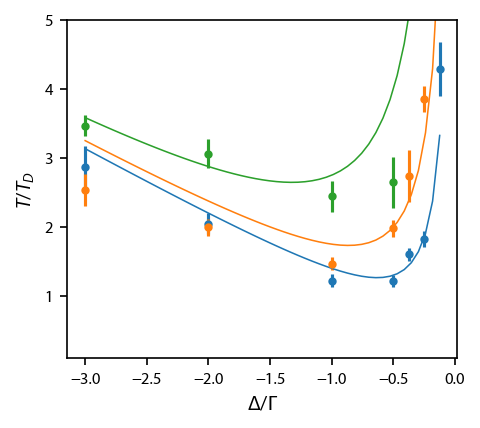

In [14]:
deltas_thr = np.linspace(-3, -0.125, 51)
fig, ax = plt.subplots(1, 1)
for ii, (s, sigmas, err) in enumerate(zip(intensities, it.operands[2], it.operands[3])):
    plt.errorbar(deltas, 2*sigmas**2*mass, 4*sigmas*err*mass, fmt='.', color='C%d'%ii)
    plt.plot(deltas_thr, lett_temperature(s, deltas_thr), linewidth=0.75, color='C%d'%ii)
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$T/T_D$')
ax.set_ylim((0.1, 5));

In [15]:
fig.savefig('20210604T0800_heuristic_eqn.pdf')